In [1]:
%reload_ext autotime
import pandas as pd
import requests
import geopandas as gpd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import time
import os
from glob import glob
from coastsat import SDS_transects
import json
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

True

In [2]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

area id_sorted      northing  \
id                                              
nzd0001  3.069093e+06   nzd0001 -4.085604e+06   
nzd0002  1.507931e+06   nzd0002 -4.086100e+06   
nzd0003  2.484730e+06   nzd0003 -4.087232e+06   
nzd0006  9.619509e+05   nzd0004 -4.090732e+06   
nzd0007  3.109433e+06   nzd0005 -4.095516e+06   
...               ...       ...           ...   
nzd0313  2.291974e+07   nzd0558 -4.939929e+06   
nzd0314  3.124363e+07   nzd0559 -4.943102e+06   
nzd0561  8.710035e+05   nzd0560 -5.905869e+06   
nzd0562           NaN      None           NaN   
nzd0563           NaN      None           NaN   

                                                  geometry  
id                                                          
nzd0001  POLYGON ((172.96406 -34.43054, 172.99324 -34.4...  
nzd0002  POLYGON ((172.93456 -34.42857, 172.95856 -34.4...  
nzd0003  POLYGON ((173.0098 -34.42055, 173.00088 -34.44...  
nzd0006  POLYGON ((173.00532 -34.46694, 173.00612 -34.4...  
nzd0007  POLYGON ((172.99847 -34.48102, 173.00081 -34.5...  
...                                                    ...  
nzd0313  POLYGON ((172.89281 -40.50518, 172.73306 -40.5...  
nzd0314  POLYGON ((173.04122 -40.54521, 172.89309 -40.5...  
nzd0561  POLYGON ((168.53017 -46.77383, 168.52 -46.7786...  
nzd0562  POLYGON ((174.90844 -36.8799, 174.90844 -36.86...  
nzd0563  POLYGON ((176.9378 -39.33472, 176.93374 -39.33...  

[562 rows x 4 columns]

1999-08-17 22:10:00+00:00 POINT (172.97690966086745 -34.42150701355086)


<Axes: xlabel='time'>

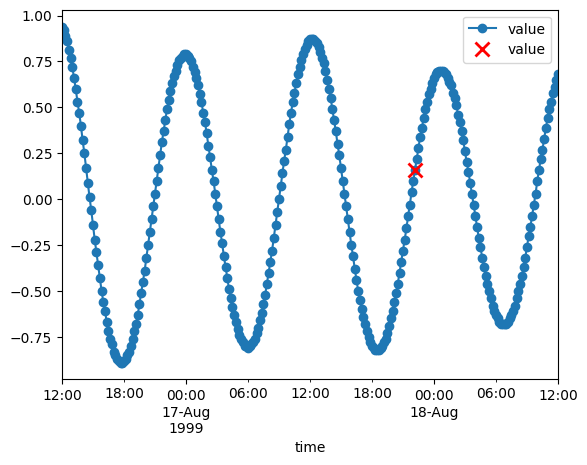

In [3]:
sitename = "nzd0001"
dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
point = poly.geometry[sitename].centroid
datetime = dates.iloc[0]
print(datetime, point)
r = requests.get("https://api.niwa.co.nz/tides/data", params={
    "lat": point.y,
    "long": point.x,
    "numberOfDays": 2,
    "startDate": str(datetime.date()),
    "datum": "MSL",
    "interval": 10, # 10 minute resolution
    "apikey": os.environ["NIWA_API_KEY"]
}, timeout=(30,30))
df = pd.DataFrame(r.json()["values"])
df.index = pd.to_datetime(df.time)
ax = df.plot(style="o-")
df[df.index == datetime].plot(color="red", style="x", ax=ax, mew=2, ms=10)

In [4]:
datetime, datetime.tz_convert("Pacific/Auckland")

(Timestamp('1999-08-17 22:10:00+0000', tz='UTC'),
 Timestamp('1999-08-18 10:10:00+1200', tz='Pacific/Auckland'))

When I asked for 1 day (1999-08-17), I got 1999-08-16 12:00 - 1999-08-17 12:00. Have to request 2 days, then pull out the one datetime I want

In [5]:
files = pd.DataFrame({"filename": sorted(glob("data/nzd*/transect_time_series.csv"))})
files["sitename"] = files.filename.str.split("/").str[1]
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))
files

filename sitename  have_tides
0    data/nzd0001/transect_time_series.csv  nzd0001        True
1    data/nzd0002/transect_time_series.csv  nzd0002        True
2    data/nzd0003/transect_time_series.csv  nzd0003        True
3    data/nzd0004/transect_time_series.csv  nzd0004        True
4    data/nzd0005/transect_time_series.csv  nzd0005        True
..                                     ...      ...         ...
557  data/nzd0559/transect_time_series.csv  nzd0559        True
558  data/nzd0560/transect_time_series.csv  nzd0560        True
559  data/nzd0561/transect_time_series.csv  nzd0561        True
560  data/nzd0562/transect_time_series.csv  nzd0562        True
561  data/nzd0563/transect_time_series.csv  nzd0563        True

[562 rows x 3 columns]

In [6]:
def get_tide_for_dt(point, datetime):
    while True:
        try:
            r = requests.get("https://api.niwa.co.nz/tides/data", params={
                "lat": point.y,
                "long": point.x,
                "numberOfDays": 2,
                "startDate": str(datetime.date()),
                "datum": "MSL",
                "interval": 10, # 10 minute resolution
                "apikey": os.environ["NIWA_API_KEY"]
            }, timeout=(30,30))
        except Exception as e:
            print(e)
            time.sleep(5)
            continue
        if r.status_code == 200:
            df = pd.DataFrame(r.json()["values"])
            df.index = pd.to_datetime(df.time)
            return df.value[datetime]
        elif r.status_code == 429:
            sleep_seconds = 30
            # sleep for x seconds to refresh the count
            print(f'Num of API reqs exceeded, Sleeping for: {sleep_seconds} seconds...')
            time.sleep(sleep_seconds)

for sitename in tqdm(files[~files.have_tides].sitename):
    dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
    point = poly.geometry[sitename].centroid

    results = []
    for date in tqdm(dates):
        result = get_tide_for_dt(point, date)
        results.append({
            "dates": date,
            "tide": result
        })
    df = pd.DataFrame(results)
    df.set_index("dates", inplace=True)
    df.to_csv(f"data/{sitename}/tides.csv")

0it [00:00, ?it/s]

In [7]:
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))

In [8]:
# Transects, origin is landward. Has beach_slope
transects = gpd.read_file("transects_extended.geojson").to_crs(2193).drop_duplicates(subset="id")
transects.set_index("id", inplace=True)
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
aus0001-0000  aus0001   104.347648    0.000000         0.000000        0.085   
aus0001-0001  aus0001    93.495734   98.408334         0.002935        0.050   
aus0001-0002  aus0001    82.069341  198.408334         0.005918        0.050   
aus0001-0003  aus0001    81.192757  298.402523         0.008900        0.055   
aus0001-0004  aus0001    81.065473  398.402523         0.011882        0.075   
...               ...          ...         ...              ...          ...   
sar2541-0000  sar2541          NaN         NaN              NaN          NaN   
sar2541-0001  sar2541          NaN         NaN              NaN          NaN   
sar2541-0002  sar2541          NaN         NaN              NaN          NaN   
sar2541-0003  sar2541          NaN         NaN              NaN          NaN   
sar2541-0004  sar2541          NaN         NaN              NaN          NaN   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
aus0001-0000  0.0545  0.2000 -1.441081     767.0           428.0  0.168420   
aus0001-0001  0.0387  0.0640 -1.037105     767.0           569.0  0.097874   
aus0001-0002  0.0428  0.0647 -0.680019     767.0           588.0  0.053927   
aus0001-0003  0.0480  0.0659 -0.405198     767.0           598.0  0.023412   
aus0001-0004  0.0614  0.0922 -0.090025     767.0           608.0  0.001277   
...              ...     ...       ...       ...             ...       ...   
sar2541-0000     NaN     NaN -0.297976    1371.0          1371.0  0.203601   
sar2541-0001     NaN     NaN  0.011742    1371.0          1371.0  0.000671   
sar2541-0002     NaN     NaN  0.048766    1371.0          1371.0  0.008370   
sar2541-0003     NaN     NaN -0.212156    1371.0          1371.0  0.135324   
sar2541-0004     NaN     NaN -1.424914    1371.0          1371.0  0.750608   

                    mae          mse       rmse   intercept ERODIBILITY  \
id                                                                        
aus0001-0000  28.102591  1263.560863  35.546601  179.085729        None   
aus0001-0001  25.419324  1033.770813  32.152306  212.247788        None   
aus0001-0002  22.632907   838.007507  28.948359  205.106151        None   
aus0001-0003  20.749758   698.653187  26.432048  191.745881        None   
aus0001-0004  19.889328   655.810616  25.608800  175.092121        None   
...                 ...          ...        ...         ...         ...   
sar2541-0000   5.662483    50.986351   7.140473  199.127124        High   
sar2541-0001   3.998349    30.150238   5.490923  165.933848        High   
sar2541-0002   4.829729    41.363000   6.431407  161.418975        High   
sar2541-0003   5.148677    42.220947   6.497765  182.397918        High   
sar2541-0004   7.903430    99.034737   9.951620  416.753361        High   

                                                       geometry  
id                                                               
aus0001-0000  LINESTRING (-422245.836 7118667.88, -421827.54...  
aus0001-0001  LINESTRING (-422256.313 7118525.222, -421837.6...  
aus0001-0002  LINESTRING (-422219.773 7118383.012, -421816.8...  
aus0001-0003  LINESTRING (-422187.543 7118279.615, -421786.5...  
aus0001-0004  LINESTRING (-422155.665 7118178.983, -421754.9...  
...                                                         ...  
sar2541-0000  LINESTRING (221259.334 25570999.948, 221214.83...  
sar2541-0001  LINESTRING (221234.016 25570996.245, 221189.51...  
sar2541-0002  LINESTRING (221166.734 25570998.184, 221206.05...  
sar2541-0003  LINESTRING (221134.919 25571003.411, 221187.40...  
sar2541-0004  LINESTRING (221015.108 25571067.588, 221258.27...  

[147170 rows x 17 columns]

In [9]:
def despike(chainage, threshold=40):
    chainage = chainage.dropna()
    chainage, dates = SDS_transects.identify_outliers(chainage.tolist(), chainage.index.tolist(), threshold)
    return pd.Series(chainage, index=dates)

def process_sitename(sitename):
    transects_at_site = transects[transects.site_id == sitename]
    assert len(transects_at_site)
    raw_intersects = pd.read_csv(f"data/{sitename}/transect_time_series.csv")#.drop(columns=["Unnamed: 0"])
    sat_times = pd.to_datetime(raw_intersects.dates).dt.round("10min")
    raw_intersects.set_index("dates", inplace=True)
    raw_intersects.index = pd.to_datetime(raw_intersects.index)
    tides = pd.read_csv(f"data/{sitename}/tides.csv")
    tides.set_index("dates", inplace=True)
    tides.index = pd.to_datetime(tides.index)
    tides = tides[tides.index.isin(sat_times)]
    if not all(sat_times.isin(tides.index)):
        dates = sat_times[~sat_times.isin(tides.index)]
        print(f"Fetching missing tides for {len(dates)} dates at {sitename}")
        point = poly.geometry[sitename].centroid
        results = []
        for date in tqdm(dates):
            result = get_tide_for_dt(point, date)
            results.append({
                "dates": date,
                "tide": result
            })
        new_tides = pd.DataFrame(results)
        new_tides.dates = pd.to_datetime(new_tides.dates)
        new_tides.set_index("dates", inplace=True)
        tides = pd.concat([tides, new_tides])
        tides.sort_index(inplace=True)
        tides.to_csv(f"data/{sitename}/tides.csv")
    corrections = tides.tide.apply(lambda tide: tide / transects_at_site.beach_slope.interpolate().bfill().ffill()).set_index(raw_intersects.index)
    corrections.columns = corrections.columns.astype(str)
    tidally_corrected = raw_intersects + corrections
    tidally_corrected = tidally_corrected.drop(columns="satname").apply(despike, axis=0)
    tidally_corrected.index.name = "dates"
    if len(tidally_corrected) == 0:
        print(f"Despike removed all points for {sitename}")
    tidally_corrected["satname"] = raw_intersects.satname
    tidally_corrected.to_csv(f"data/{sitename}/transect_time_series_tidally_corrected.csv")
    return tidally_corrected

_ = process_map(process_sitename, files.sitename)
#process_sitename("nzd0562")

Fetching missing tides for 1 dates at nzd0011

Fetching missing tides for 1 dates at nzd0001

Fetching missing tides for 2 dates at nzd0029

  0%|          | 0/562 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0003

Fetching missing tides for 2 dates at nzd0002

Fetching missing tides for 1 dates at nzd0015

Fetching missing tides for 1 dates at nzd0006

Fetching missing tides for 1 dates at nzd0013

Fetching missing tides for 1 dates at nzd0014

Fetching missing tides for 1 dates at nzd0020

Fetching missing tides for 1 dates at nzd0008

Fetching missing tides for 1 dates at nzd0018

Fetching missing tides for 2 dates at nzd0021

Fetching missing tides for 1 dates at nzd0009

Fetching missing tides for 2 dates at nzd0005

Fetching missing tides for 2 dates at nzd0022

Fetching missing tides for 2 dates at nzd0028

Fetching missing tides for 2 dates at nzd0004

Fetching missing tides for 2 dates at nzd0023

Fetching missing tides for 3 dates at nzd0024

Fetching missing tides for 2 dates at nzd0027

Fetching missing tides for 2 dates at nzd0031

Fetching missing tides for 1 dates at nzd0016

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0032

Fetching missing tides for 1 dates at nzd0019

Fetching missing tides for 2 dates at nzd0030

Fetching missing tides for 3 dates at nzd0026

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0033

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0034

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 3 dates at nzd0035

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0036

Fetching missing tides for 3 dates at nzd0037

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0038

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0039

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0040

Fetching missing tides for 3 dates at nzd0041

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0042

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0043

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0044

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0045

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0046

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0047

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0048

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0049

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 3 dates at nzd0050

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0051

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0052

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0053

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0054

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0055

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0056

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0057

*

*

*

Fetching missing tides for 1 dates at nzd0058

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0060

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0061

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0062

Fetching missing tides for 1 dates at nzd0063

Fetching missing tides for 1 dates at nzd0064

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0065

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0066

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0068

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0069

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0083

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0085

Fetching missing tides for 1 dates at nzd0084

Fetching missing tides for 1 dates at nzd0086

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0087

Fetching missing tides for 1 dates at nzd0088

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0089

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0093

*

Fetching missing tides for 1 dates at nzd0094

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0095

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0097

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0098

Fetching missing tides for 1 dates at nzd0099

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0100

Fetching missing tides for 1 dates at nzd0102

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0103

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0105

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0109

*

Fetching missing tides for 2 dates at nzd0110

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0111

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0112

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0113

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0116

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0117

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0118

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0120

Fetching missing tides for 1 dates at nzd0119

Fetching missing tides for 1 dates at nzd0121

*

Fetching missing tides for 1 dates at nzd0122

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0127

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0128

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0129

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0130

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0131

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0133

*

*

*

Fetching missing tides for 1 dates at nzd0134

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0135

*

*

Fetching missing tides for 1 dates at nzd0137

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0138

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0140

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0141

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0143

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0144

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0145

*

*

*

Fetching missing tides for 1 dates at nzd0146

Fetching missing tides for 1 dates at nzd0147

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0148

Fetching missing tides for 1 dates at nzd0149

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0151

*

*

*

*

Fetching missing tides for 1 dates at nzd0152

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0153

*

*

*

Fetching missing tides for 1 dates at nzd0154

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0155

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0156

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0157

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0158

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0159

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 1 dates at nzd0160

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0161

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0162

*

*

Fetching missing tides for 1 dates at nzd0163

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0164

*

Fetching missing tides for 2 dates at nzd0165

*

*

*

*

Fetching missing tides for 1 dates at nzd0166

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0167

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0168

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0169

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0170

*

*

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0171

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0172

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0173

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0174

*

Fetching missing tides for 1 dates at nzd0175

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0176

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0177

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0178

Fetching missing tides for 1 dates at nzd0179

Fetching missing tides for 1 dates at nzd0180

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0181

*

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 2 dates at nzd0182

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0184

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0185

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0186

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0187

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0188

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0189

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0190

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 3 dates at nzd0191

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0192

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0193

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 4 dates at nzd0194

Fetching missing tides for 4 dates at nzd0195

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0196

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0197

Fetching missing tides for 3 dates at nzd0198

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0199

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0200

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0201

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0202

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0203

Fetching missing tides for 3 dates at nzd0204

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0205

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0206

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0207

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0208

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0209

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0210

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0212

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0213

Fetching missing tides for 2 dates at nzd0214

Fetching missing tides for 2 dates at nzd0215

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0216

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 3 dates at nzd0217

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0219

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0220

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0221

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0222

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0223

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0227

*

Fetching missing tides for 2 dates at nzd0226

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0229

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0230

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0231

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0233

*

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0234

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0235

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0236

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0237

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0238

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 3 dates at nzd0239

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0240

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0242

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0243

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0246

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0248

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0249

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0250

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0252

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0253

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0254

*

Fetching missing tides for 1 dates at nzd0255

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0256

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0257

Fetching missing tides for 1 dates at nzd0258

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0259

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0260

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0261

Fetching missing tides for 2 dates at nzd0262

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0263

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0264

*

Fetching missing tides for 1 dates at nzd0265

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0266

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0267

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0268

Fetching missing tides for 1 dates at nzd0269

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0270

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0272

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0273

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0274

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0276

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0277

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0278

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0280

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0281

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0282

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0284

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0285

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0286

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0287

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0288

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0289

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0290

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 1 dates at nzd0291

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0292

*

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0293

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0294

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0295

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0296

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0297

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0298

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0299

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0300

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 2 dates at nzd0301

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 1 dates at nzd0302

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0303

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 2 dates at nzd0304

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0305

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0306

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0307

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0308

*

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0309

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0310

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0311

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0312

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0314

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0315

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 1 dates at nzd0318

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0319

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0320

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0321

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0322

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0323

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0324

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0325

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0326

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0327

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0328

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0329

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0330

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0331

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0332

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0333

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0334

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0335

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0336

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0337

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0338

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0339

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0340

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0341

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0342

  0%|          | 0/4 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0343

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0344

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0346

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0350

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0353

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0365

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0366

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0367

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0368

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0371

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0372

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0376

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0379

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0380

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0382

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0383

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0398

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0400

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0404

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0409

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0413

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0414

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0416

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0417

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0418

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0419

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0421

*

Fetching missing tides for 1 dates at nzd0422

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0423

*

Fetching missing tides for 1 dates at nzd0424

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0426

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0427

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0429

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0431

*

*

Fetching missing tides for 3 dates at nzd0432

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0433

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0435

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0436

*

*

*

Fetching missing tides for 3 dates at nzd0438

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0439

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0441

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0442

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0443

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0444

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0445

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0446

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0449

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0450

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0452

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0453

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0455

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0456

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0458

Fetching missing tides for 2 dates at nzd0460

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0463

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0465

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0467

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0468

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0469

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0473

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0474

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0475

Fetching missing tides for 2 dates at nzd0476

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0477

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0478

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0479

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0480

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0481

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0482

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0483

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 1 dates at nzd0484

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0485

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 1 dates at nzd0486

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0487

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0488

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0489

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0490

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0491

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0492

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0494

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0517

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0523

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0532

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0533

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0534

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0535

*

Fetching missing tides for 2 dates at nzd0536

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0539

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0540

Fetching missing tides for 1 dates at nzd0541

*

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0543

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0544

*

*

Fetching missing tides for 1 dates at nzd0545

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0548

Fetching missing tides for 2 dates at nzd0549

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0550

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0551

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0553

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Despike removed all points for nzd0555

*

Fetching missing tides for 2 dates at nzd0558

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0561

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0562

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0563

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*